# Data Story Telling

**Table of Content**

1. Introduction  
   1.1. Library  
   1.2. Load data sets  
  
2. Claim Evolution over the years  
   2.1. Claims per seasons  
   2.2. Temperature and snow/rain effects on the number of claims  
   2.3. Variation of the repair delay over the years  
   2.4. Temperature and snow/rain effects on the repair time  
  
3. Number of claims vs. time for repair
  
4. Intersections 
  
5. Population
  
6. Claim distribution per neighborhood  
  
7. Time for repair per neighborhood

8. Specific case study

# 1. Introduction

This notebook is part of the data story telling module. The purpose of this notebook is to explore the data extracted from:
- 00_Data_Wrangling-Weather.ipynb
- 01_Data_Wrangling_Boston.ipynb
- 02a_Data_Wrangling_Potholes.ipynb
- 02b_Google_Geo_API_Fetcher.ipynb

The corresponding data files are stored in the following folders:
- *./Original Data*
- *./Intermediate Data*
- *./Cleaned Data*

The methodology used to cleaned the files is described in the **Data Wrangling Report** (*./Data Wrangling Report.pdf*)

**Questions**

Through this notebook, the following questions will be investigated:
1. Are repairs faster/slower in certain neighborhoods?
2. How does the weather impact the number of claims?
3. How does the weather impact the repair time?

## 1.1. Library

In [180]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

import math
import calendar

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

import folium

import datetime

## 1.2. Load data sets

In [181]:
potholes_df = pd.read_csv('./Cleaned Data/Closed_Pothole_Cases_Cleaned.csv',
                          parse_dates=['CLOSED_DT','OPEN_DT','TARGET_DT'],
                          index_col=0)
weather_df = pd.read_csv('./Cleaned Data/Weather_Data_Cleaned.csv',index_col='DATE',parse_dates=True)
boston_zip_df = pd.read_csv('./Cleaned Data/Boston_Pop_Cleaned.csv',index_col='zipcode')

Confirm that the import was successful:

In [182]:
# Display df shapes
print(potholes_df.shape)
print(weather_df.shape)
print(boston_zip_df.shape)

(35434, 27)
(211, 21)
(30, 6)


In [183]:
# Display df structures
print(potholes_df.info())
print('----------------------')
print(weather_df.info())
print('----------------------')
print(boston_zip_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35434 entries, 0 to 14251
Data columns (total 27 columns):
CASE_ENQUIRY_ID                   35434 non-null int64
CASE_STATUS                       35434 non-null object
CASE_TITLE                        35434 non-null object
CLOSED_DT                         35434 non-null datetime64[ns]
CLOSURE_REASON                    35434 non-null object
ClosedPhoto_Bool                  35434 non-null bool
LATITUDE                          35434 non-null float64
LOCATION_STREET_NAME              35434 non-null object
LOCATION_ZIPCODE                  35434 non-null float64
LONGITUDE                         35434 non-null float64
Location                          35434 non-null object
OPEN_DT                           35434 non-null datetime64[ns]
OnTime_Status                     35433 non-null object
OnTime_Status_Bool                35434 non-null bool
QUEUE                             35434 non-null object
Source                            354

# 2. Claim evolution over the years

## 2.1. Claim per seasons

In order to get a sense of the efficiency of the Departement of Transportation, we are going to investigate the evolution of the number of claims over the years. 

In [184]:
# Prepare dataframe
yearly_claim_df = potholes_df[['OPEN_DT','CASE_ENQUIRY_ID']].copy()
yearly_claim_df.OPEN_DT = yearly_claim_df.OPEN_DT.apply(lambda x: x.replace(day=(x.day//16*15+1))).dt.date

# Add season for visual inspection
season_dict = {
    1: 'Winter',
    2: 'Spring',
    3: 'Spring',
    4: 'Spring',
    5: 'Summer',
    6: 'Summer',
    7: 'Summer',
    8: 'Fall',
    9: 'Fall',
    10: 'Fall',
    11: 'Winter',
    12: 'Winter',
}

yearly_claim_df = yearly_claim_df.groupby('OPEN_DT').count()

yearly_claim_df['Season'] = yearly_claim_df.index.map(lambda x: season_dict[x.month])
yearly_claim_df.head()

CASE_ENQUIRY_ID  Season
OPEN_DT                            
2011-07-01              117  Summer
2011-07-16               66  Summer
2011-08-01               82    Fall
2011-08-16               96    Fall
2011-09-01               68    Fall

In [185]:
yearly_claim_season_df = yearly_claim_df.groupby('Season').sum()
yearly_claim_season_df

CASE_ENQUIRY_ID
Season                 
Fall               3902
Spring            16505
Summer             7766
Winter             7261

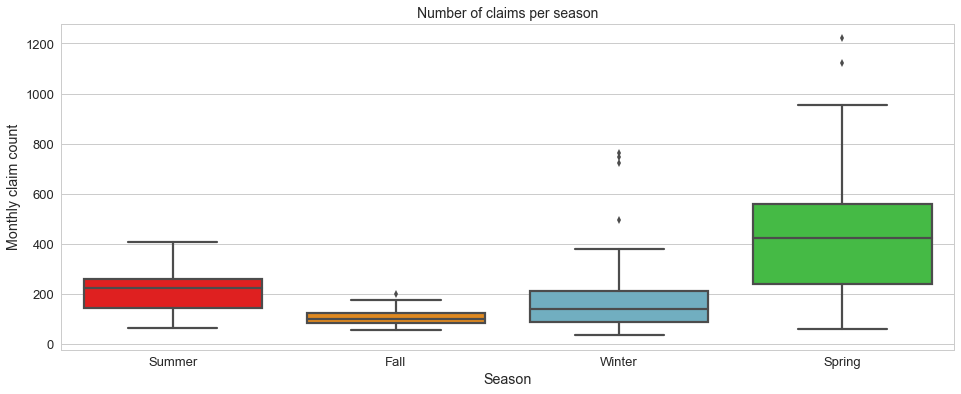

In [186]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.2})
fig, ax = plt.subplots(figsize=(16,6))
sns.boxplot(x='Season',y="CASE_ENQUIRY_ID",
            data=yearly_claim_df,
            palette = sns.color_palette(['red','darkorange','c','limegreen']))
ax.set(xlabel="Season",ylabel='Monthly claim count')
plt.title('Number of claims per season', fontsize=14);

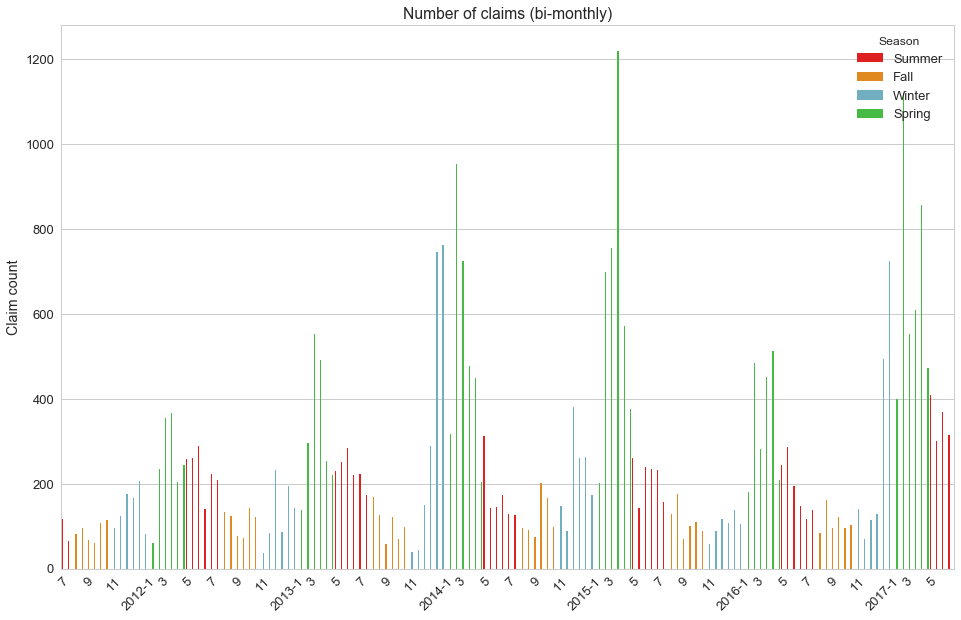

In [187]:
# Set main plot parameters
sns.set_style("whitegrid")

# Create x labels using list comprehension
x_label = [str(x.year)+"-"+str(x.month) if x.day==1 and x.month==1 else
           (x.month) if x.day==1 and x.month%2==1 else '' for x in yearly_claim_df.index]

# Plot
fig, ax = plt.subplots(figsize=(16,10))
ax = sns.barplot(x=yearly_claim_df.index,
                 y=yearly_claim_df.CASE_ENQUIRY_ID,hue=yearly_claim_df.Season,
                 palette = sns.color_palette(['red','darkorange','c','limegreen']))

# Set plot labels
ax.set_title("Number of claims (bi-monthly)")
ax.set(xlabel="",ylabel='Claim count')
ax.set_xticklabels(x_label,rotation=45)

plt.show()

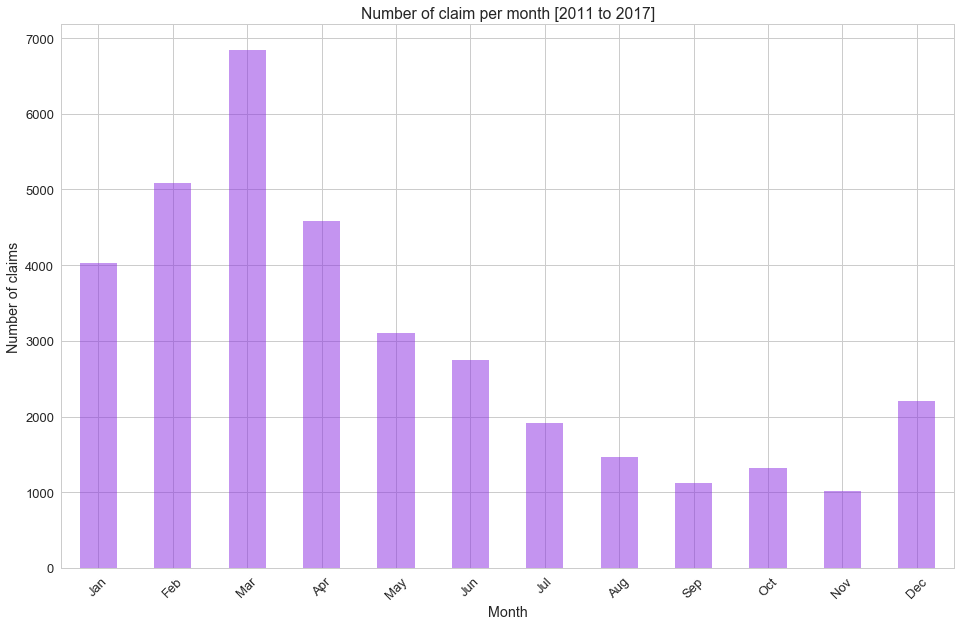

In [188]:
# Group the number of reported cases by month
yearly_claim_df.index = pd.to_datetime(yearly_claim_df.index)
to_plot = yearly_claim_df.groupby(by=yearly_claim_df.index.month).sum()

to_plot['Month_Name'] = to_plot.index
to_plot.Month_Name = to_plot.Month_Name.apply(lambda x: calendar.month_abbr[x])
to_plot.set_index(to_plot.Month_Name,inplace=True,drop=True)

to_plot.plot(figsize=(16,10),kind='bar',rot=45,color='blueviolet',alpha=0.5);
plt.xlabel('Month')
plt.ylabel('Number of claims')
plt.title('Number of claim per month [2011 to 2017]')
plt.legend().set_visible(False)
plt.show();

As expected, more potholes appear after a the winter. Based on the above plots, the number of claims is maximum over teh January to April time period. We can make two conclusions:
 1. The claim number peaks during the spring. Indeed, in order to form, a pothole needs to freeze and unfreeze multiple times. The lag can be estimated to couple weeks to 1~2 months. We will investigate the lag that creates the maximum correlation between the weather conditions and the number of claims.
 2. The pothole appearance is positively correlated to the snow amount and negatively correlated with the  temperatures. Both 2014 and 2015 winters were famous for the amount of snow that fell in the region while the winter of 2016 was a lot warmer.
 
In order to validate the second claim, we will use the plot above and we will superimpose the snowfall and temperature variation.

## 2.2. Temperature and snow/rain effects on the number of claims

As we saw previously, it seems that there is a small lage between the number of potholes during a month and how freezing the previous months were. In order to estimate the lag, we will first plot some weather data in order to indentify which month were the ones with the largest number of freezing days and the ones with the largest snowfalls.

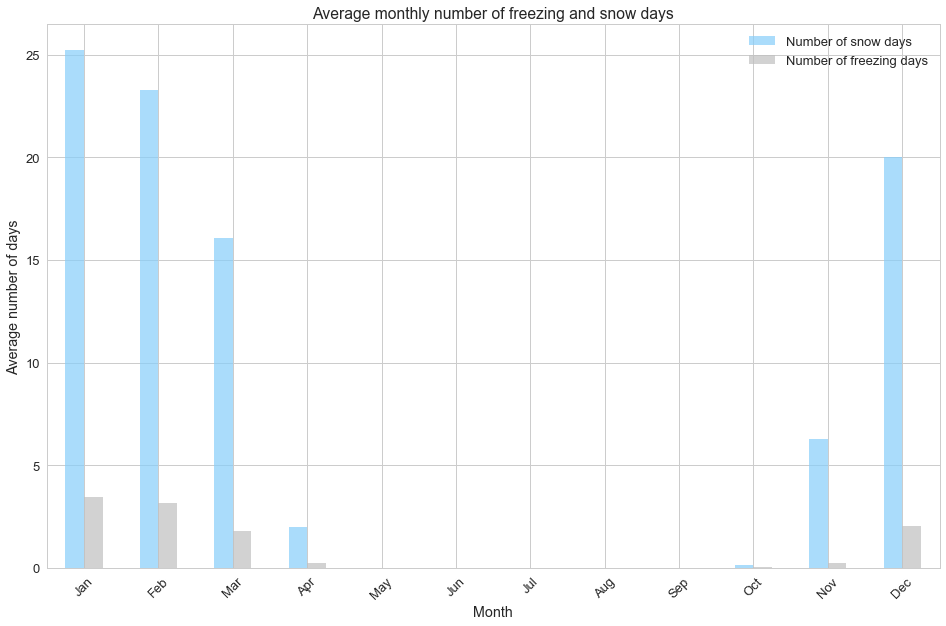

In [189]:
# Create a custom data frame to plot the data
to_plot = weather_df.loc['2011':,['DT32','DSNW']]

# Group the data by mean
to_plot = weather_df[['DT32','DSNW']].groupby(by=weather_df.index.month).mean()

# Extract month number for plotting purpose
to_plot['Month_Name'] = to_plot.index
to_plot.Month_Name = to_plot.Month_Name.apply(lambda x: calendar.month_abbr[x])
to_plot.set_index(to_plot.Month_Name,inplace=True,drop=True)


to_plot[['DT32','DSNW']].plot(figsize=(16,10),kind='bar',rot=45,color=['lightskyblue','silver'],alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Average number of days')
plt.title('Average monthly number of freezing and snow days')
plt.legend(['Number of snow days','Number of freezing days'])
plt.show();

As shown above, the months of January, February, and December are the ones with the largest number of both freezing and snow days. Since the pothole request count peaks in March, we should expect to see the maximum correlation between the weather data (DSNW and DT32) and the number of claims when the weather data is shifted forward 1 or 2 months.

In [190]:
# Prepare dataframe
yearly_claim_offset_df = potholes_df[['OPEN_DT','CASE_ENQUIRY_ID']].copy()
yearly_claim_offset_df.OPEN_DT = yearly_claim_offset_df.OPEN_DT.apply(lambda x: x.replace(day=1)).dt.date

# Add season for visual inspection
season_dict = {
    1: 'Winter',
    2: 'Spring',
    3: 'Spring',
    4: 'Spring',
    5: 'Summer',
    6: 'Summer',
    7: 'Summer',
    8: 'Fall',
    9: 'Fall',
    10: 'Fall',
    11: 'Winter',
    12: 'Winter',
}

# We create the season feature
yearly_claim_offset_df = yearly_claim_offset_df.groupby('OPEN_DT').count()
yearly_claim_offset_df['Season'] = yearly_claim_offset_df.index.map(lambda x: season_dict[x.month])
yearly_claim_offset_df.head()

# Weather data
#weather_offset_df = weather_df.loc[:,['DSNW','DT32','TAVG',"DP10"]]
weather_offset_df = weather_df.copy()

# We create new features used to shift the number of claims one month at the time in the past
for shift in range(-1,-6,-1): # 1 to 6 months
    yearly_claim_offset_df["CASE_ENQUIRY_ID_Shift_"+str(shift)] = yearly_claim_offset_df.CASE_ENQUIRY_ID.shift(shift)

# Merge pothole and weather data
yearly_claim_offset_df = yearly_claim_offset_df.merge(right=weather_offset_df,how='left',left_index=True,right_index=True)

In [191]:
# Compute correlation matrix and trim the unecessary values
correlation = yearly_claim_offset_df.corr()
correlation=correlation.loc[correlation.columns.str.contains('CASE'),~correlation.index.str.contains('CASE')]
correlation

CDSD      CLDD      DP01      DP10      DSNW  \
CASE_ENQUIRY_ID          -0.641317 -0.303723  0.373235  0.199711  0.571007   
CASE_ENQUIRY_ID_Shift_-1 -0.473498 -0.421178  0.436809  0.255572  0.792182   
CASE_ENQUIRY_ID_Shift_-2 -0.194741 -0.480728  0.339657  0.177798  0.565395   
CASE_ENQUIRY_ID_Shift_-3  0.229473 -0.469620  0.274845  0.190591  0.165401   
CASE_ENQUIRY_ID_Shift_-4  0.488041 -0.361865 -0.011887  0.006734 -0.006084   
CASE_ENQUIRY_ID_Shift_-5  0.597827 -0.023953 -0.095846 -0.162799 -0.166429   

                              DT00      DT32      DX32      DX70      DX90  \
CASE_ENQUIRY_ID           0.114406  0.477656  0.407846 -0.371445 -0.194944   
CASE_ENQUIRY_ID_Shift_-1  0.398546  0.740532  0.764865 -0.523158 -0.279516   
CASE_ENQUIRY_ID_Shift_-2  0.293773  0.688322  0.602662 -0.586396 -0.352521   
CASE_ENQUIRY_ID_Shift_-3  0.030166  0.421587  0.225985 -0.547502 -0.338219   
CASE_ENQUIRY_ID_Shift_-4 -0.054826  0.131498 -0.014291 -0.347526 -0.311308   
CASE_ENQUIRY_ID_Shift_-5 -0.086017 -0.170202 -0.138382  0.019525 -0.066083   

                            ...         EMSN      EMXP      EMXT      HDSD  \
CASE_ENQUIRY_ID             ...     0.443630  0.071332 -0.370871  0.585501   
CASE_ENQUIRY_ID_Shift_-1    ...     0.745018  0.024310 -0.667121  0.426320   
CASE_ENQUIRY_ID_Shift_-2    ...     0.638738  0.047740 -0.638907  0.176139   
CASE_ENQUIRY_ID_Shift_-3    ...     0.223685  0.168626 -0.497153 -0.110456   
CASE_ENQUIRY_ID_Shift_-4    ...     0.002824  0.012534 -0.258267 -0.355141   
CASE_ENQUIRY_ID_Shift_-5    ...    -0.139973  0.021626  0.076435 -0.577744   

                              HTDD      PRCP      SNOW      TAVG      TMAX  \
CASE_ENQUIRY_ID           0.490339  0.129410  0.416291 -0.476007 -0.465918   
CASE_ENQUIRY_ID_Shift_-1  0.735375  0.138280  0.751017 -0.714384 -0.706788   
CASE_ENQUIRY_ID_Shift_-2  0.722163  0.071546  0.505906 -0.700211 -0.698878   
CASE_ENQUIRY_ID_Shift_-3  0.513333  0.131380  0.130326 -0.520225 -0.532716   
CASE_ENQUIRY_ID_Shift_-4  0.228554 -0.004537 -0.018251 -0.269127 -0.281897   
CASE_ENQUIRY_ID_Shift_-5 -0.127542 -0.093738 -0.134438  0.101266  0.086807   

                              TMIN  
CASE_ENQUIRY_ID          -0.485989  
CASE_ENQUIRY_ID_Shift_-1 -0.719922  
CASE_ENQUIRY_ID_Shift_-2 -0.699333  
CASE_ENQUIRY_ID_Shift_-3 -0.505415  
CASE_ENQUIRY_ID_Shift_-4 -0.254996  
CASE_ENQUIRY_ID_Shift_-5  0.116205  

[6 rows x 21 columns]

The correlation matrix shown below contains certain high values, however, the matrix representation is not the most convenient. We now use Seaborn heatmap to visualize the correlation matrix. Note that we only display the coefficient of correlation greater than 0.6 in absolute value.

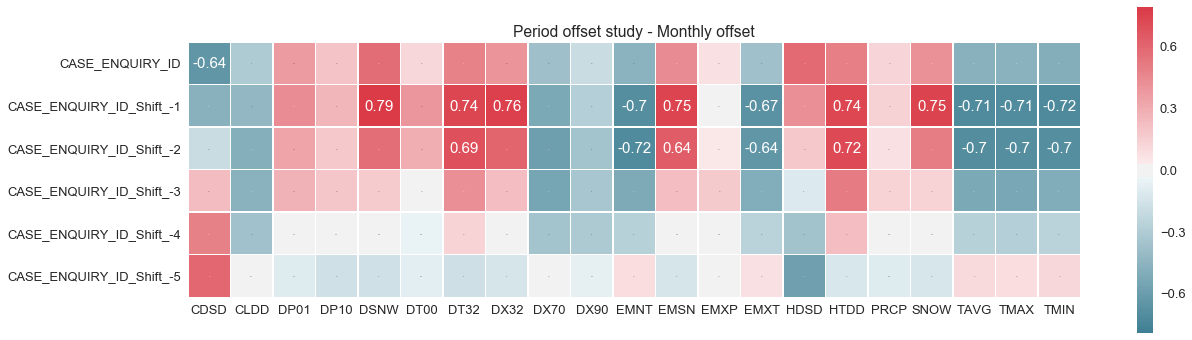

In [192]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = plt.axes()
sns.heatmap(correlation, cmap=cmap,square=True, linewidths=.5,annot=True)
ax.set_title("Period offset study - Monthly offset")

for text in ax.texts:
    if math.fabs(float(text.get_text()))>0.6:
        text.set_size(15)
    else:
        text.set_size(0)

From the study of the heamat, we can draw the following conclusions:
1. When considering the number of snow days, the maximum positive correlation is obtained for a shift of **1 month**.
2. When considering the number of freezing days, the maximum positive correlation is obtained for a shift of **1 month**.
3. When considering the extreme minimum temperature, the minimum negative correlation is similar for the **1 and 2 month shift**.
4. When considering the monthly snowfall (in inches), the maximum positive correlation is obtained for a shift of **1 month**.
5. When looking at the maximum, minimum, and average temperature, the minimum negative correlation is similar for the **1 and 2 month shift**.

However, the correlation needs to be interpreted with caution, indeed, the precipitation data (snow or rain) are highly correlated with the temperatures. The plot shown below provides the correlation between the weather data.

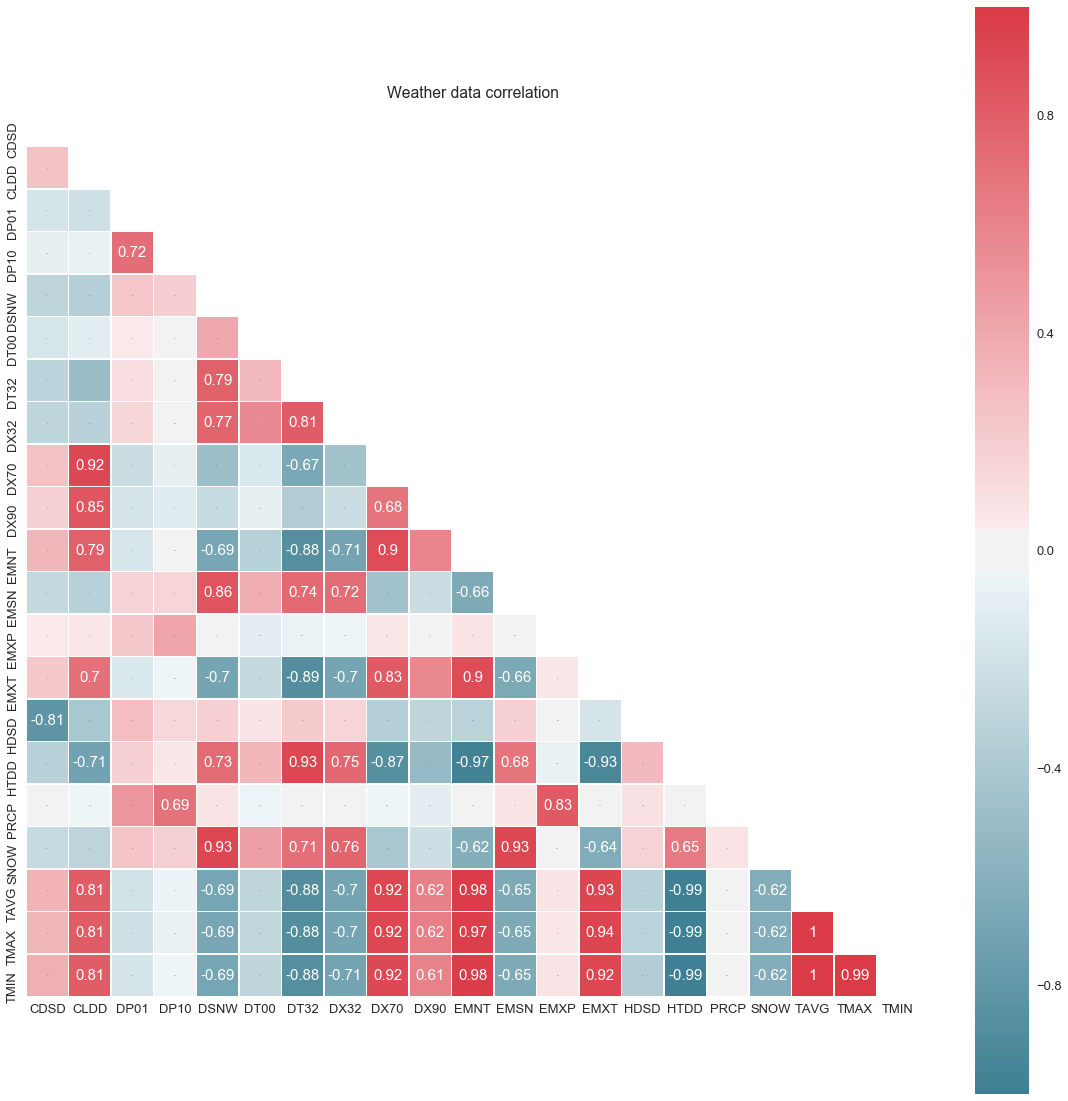

In [193]:
# Create mask
mask = np.zeros_like(weather_df.corr())
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = plt.axes()
sns.heatmap(weather_df.corr(), cmap=cmap,square=True, linewidths=.5,annot=True,mask=mask)
ax.set_title("Weather data correlation")

for text in ax.texts:
    if math.fabs(float(text.get_text()))>0.6:
        text.set_size(15)
    else:
        text.set_size(0)

Now that we have a better understanding of the overall data correlation, we can investigate specific relationships using the (-1) month offset.

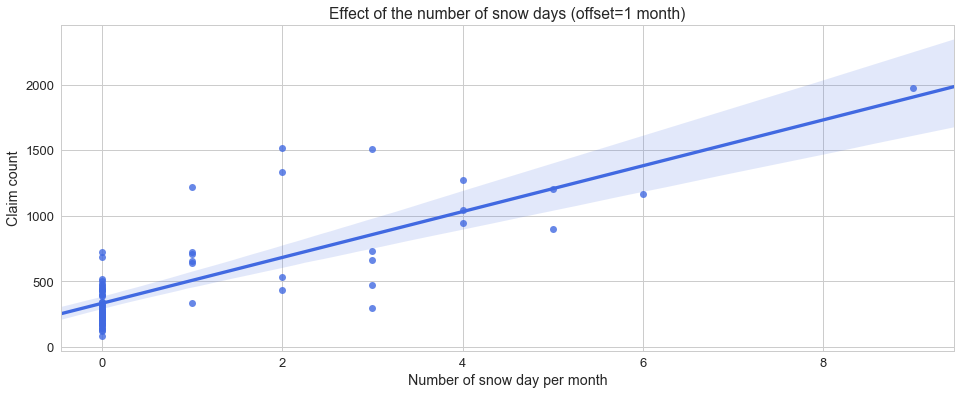

In [194]:
fig, ax = plt.subplots(figsize=(16,6))
sns.regplot(x='DSNW',y="CASE_ENQUIRY_ID_Shift_-1",data=yearly_claim_offset_df,color="royalblue")
ax.set_title("Effect of the number of snow days (offset=1 month)")
ax.set(xlabel="Number of snow day per month",ylabel='Claim count');

**Note**  
As expected, there is a clear positive correlation (0.79) between the frequency of snowfall over a month and the number of claims created the next month. It is interesting to notice the group of data point corresponding to a zero day snow fall. We will have to use other variable to investigate these cases specifically.

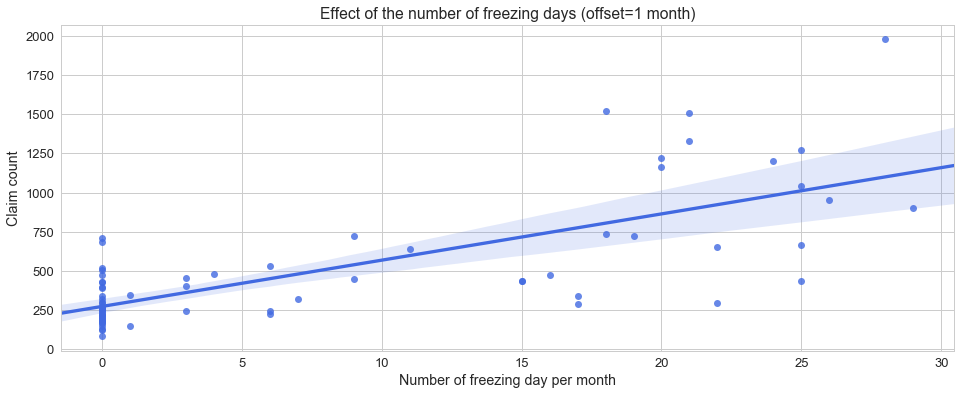

In [195]:
fig, ax = plt.subplots(figsize=(16,6))
sns.regplot(x='DT32',y="CASE_ENQUIRY_ID_Shift_-1",data=yearly_claim_offset_df,color="royalblue")
ax.set_title("Effect of the number of freezing days (offset=1 month)")
ax.set(xlabel="Number of freezing day per month",ylabel='Claim count');

**Note**  
As expected, there is a clear positive correlation (0.74) between the frequency of freezing days over a month and the number of claims created the next month. However, we have to be careful because the number of snow days is also positively correlated (0.79) with the number of freezing days (See plot below).

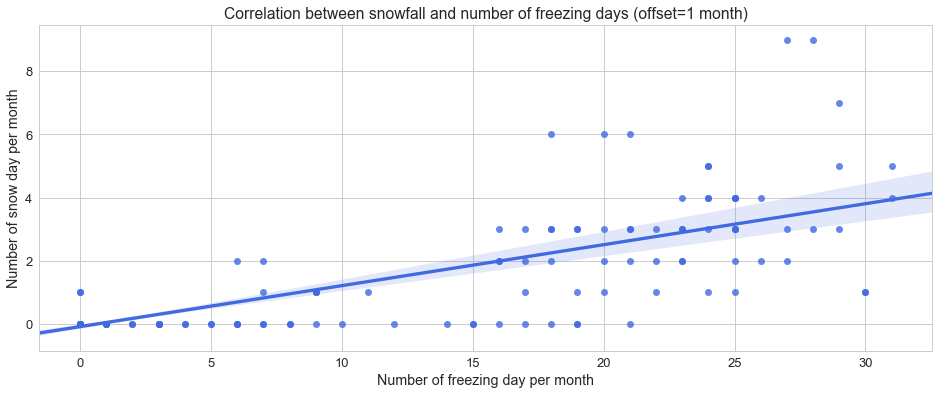

In [196]:
fig, ax = plt.subplots(figsize=(16,6))
sns.regplot(x='DT32',y="DSNW",data=weather_df,color="royalblue")
ax.set_title("Correlation between snowfall and number of freezing days (offset=1 month)")
ax.set(xlabel="Number of freezing day per month",ylabel='Number of snow day per month');

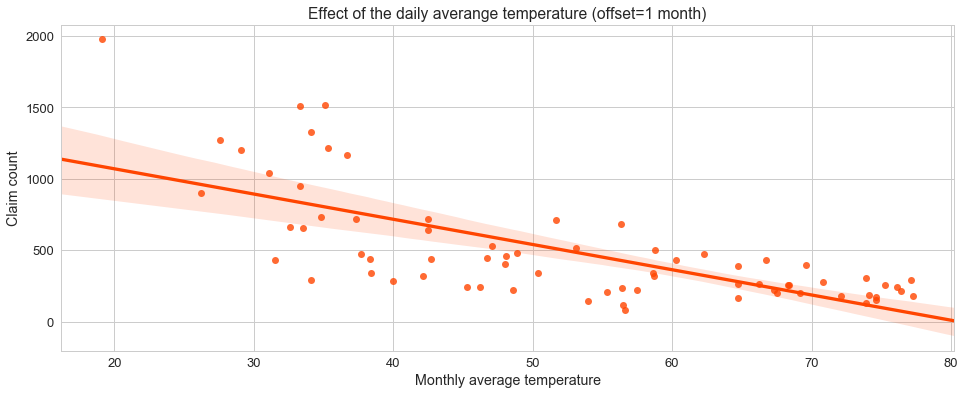

In [197]:
fig, ax = plt.subplots(figsize=(16,6))
sns.regplot(x='TAVG',y="CASE_ENQUIRY_ID_Shift_-1",data=yearly_claim_offset_df,color="orangered")
ax.set_title("Effect of the daily averange temperature (offset=1 month)")
ax.set(xlabel="Monthly average temperature",ylabel='Claim count');

**Note**  
As expected, there is a negative correlation (-0.71) between the average monthly temperature and the number of claims created the next month. The data points are closer to the regression line for higher average temperature. This can be explained by the effects of the snow at lower temperature. We can interfere that for two months with the same number of freezing days and the same average temperature, the month with the highest snowfall will produce more claims. The residual plot below confirm the data point distribution.

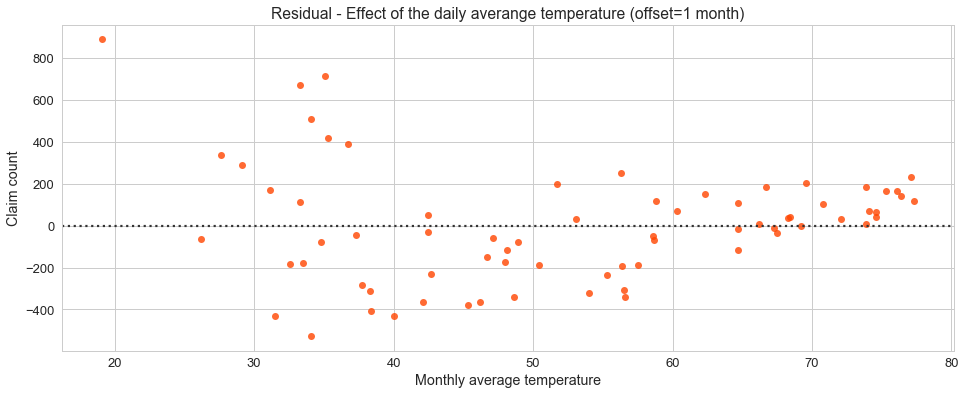

In [198]:
fig, ax = plt.subplots(figsize=(16,6))
sns.residplot(x='TAVG',y="CASE_ENQUIRY_ID_Shift_-1",data=yearly_claim_offset_df,color="orangered")
ax.set_title("Residual - Effect of the daily averange temperature (offset=1 month)")
ax.set(xlabel="Monthly average temperature",ylabel='Claim count');

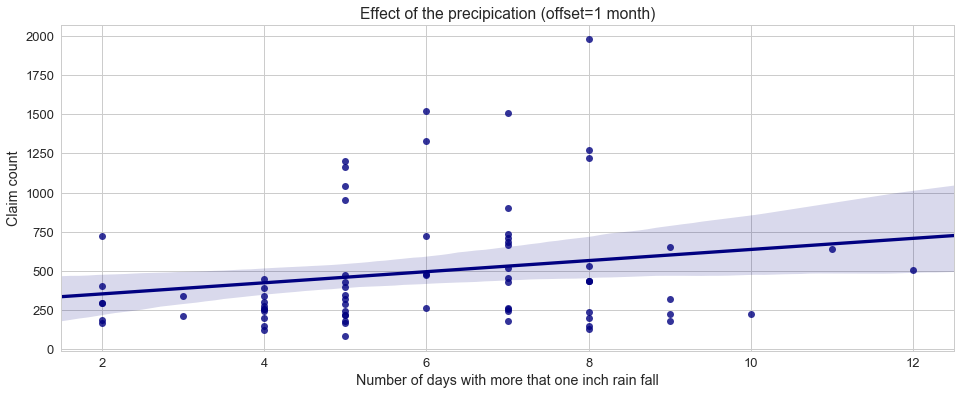

In [199]:
fig, ax = plt.subplots(figsize=(16,6))
sns.regplot(x='DP10',y="CASE_ENQUIRY_ID",data=yearly_claim_offset_df,color="navy")
ax.set_title("Effect of the precipication (offset=1 month)")
ax.set(xlabel="Number of days with more that one inch rain fall",ylabel='Claim count');

**Note**  
The correlation (0.26) between precipitation and claims is not really obvious. In conclusion, it seems that only the snow is strongly correlated with the number of claims.

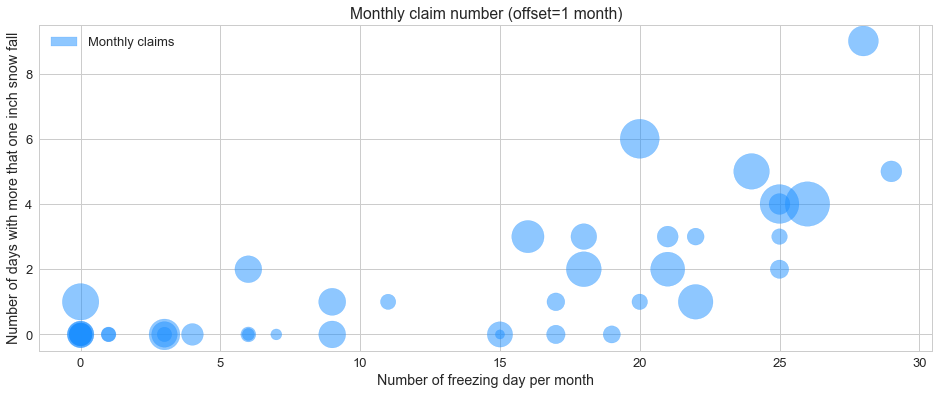

In [200]:
# Scatter plot of the monthly number of claims as a function of the snowfall and freezing days
fig, ax = plt.subplots(figsize=(16,6))
plt.scatter(x=yearly_claim_offset_df['DT32'],
            y=yearly_claim_offset_df['DSNW'],
            s=yearly_claim_offset_df['CASE_ENQUIRY_ID'],
            c = 'dodgerblue',alpha = 0.5)
ax.set_title("Monthly claim number (offset=1 month)")
ax.set(xlabel="Number of freezing day per month",ylabel='Number of days with more that one inch snow fall');

plt.legend(handles=[mpatches.Patch(color='dodgerblue', alpha=0.5,label='Monthly claims')]);

As shown above, the correlation between the number of claims and the number of freezing days and number of snow days is not exactly linear. Indeed, the bilinear relathionship develops after 15 freezing days.

## 2.3. Variation of the repair delay over the years

Now that we know the cold weather has a significant impact on the road damage frequency, we will be looking at the impact of the weather on the repair time. The repair time is defined as the difference between the claim closure date and the claim creation date. As previously stated, the pothole database can be modified by making a request to 311 or by city workers. A significant number of potholes are discovered and fixed at the same time by city workers patrolling in the street. In order to only focus on claims made by "normal" users, we will restrain the data set to potholes that took more than half a day to be fixed.

In [201]:
# Prepare dataframe
yearly_repair_time_df = potholes_df[['OPEN_DT','time_repair']].copy()
yearly_repair_time_df = yearly_repair_time_df[yearly_repair_time_df.time_repair>=0.5]

# Re-adjust the OPEN_DT to either the first day of the month or the 15th (for plotting purpose)
yearly_repair_time_df.OPEN_DT = yearly_repair_time_df.OPEN_DT.apply(lambda x: x.replace(day=(x.day//16*15+1))).dt.date

# Add season for visual inspection
season_dict = {
    1: 'Winter',
    2: 'Spring',
    3: 'Spring',
    4: 'Spring',
    5: 'Summer',
    6: 'Summer',
    7: 'Summer',
    8: 'Fall',
    9: 'Fall',
    10: 'Fall',
    11: 'Winter',
    12: 'Winter',
}

yearly_repair_time_df = yearly_repair_time_df.groupby('OPEN_DT').median()

yearly_repair_time_df['Season'] = yearly_repair_time_df.index.map(lambda x: season_dict[x.month])
yearly_repair_time_df.head()

time_repair  Season
OPEN_DT                        
2011-07-01     1.303767  Summer
2011-07-16     1.880324  Summer
2011-08-01     1.040729    Fall
2011-08-16     2.024595    Fall
2011-09-01     1.230961    Fall

In [202]:
yearly_repair_time_df.groupby('Season').median()

time_repair
Season             
Fall       1.179855
Spring     1.199578
Summer     1.103079
Winter     1.109936

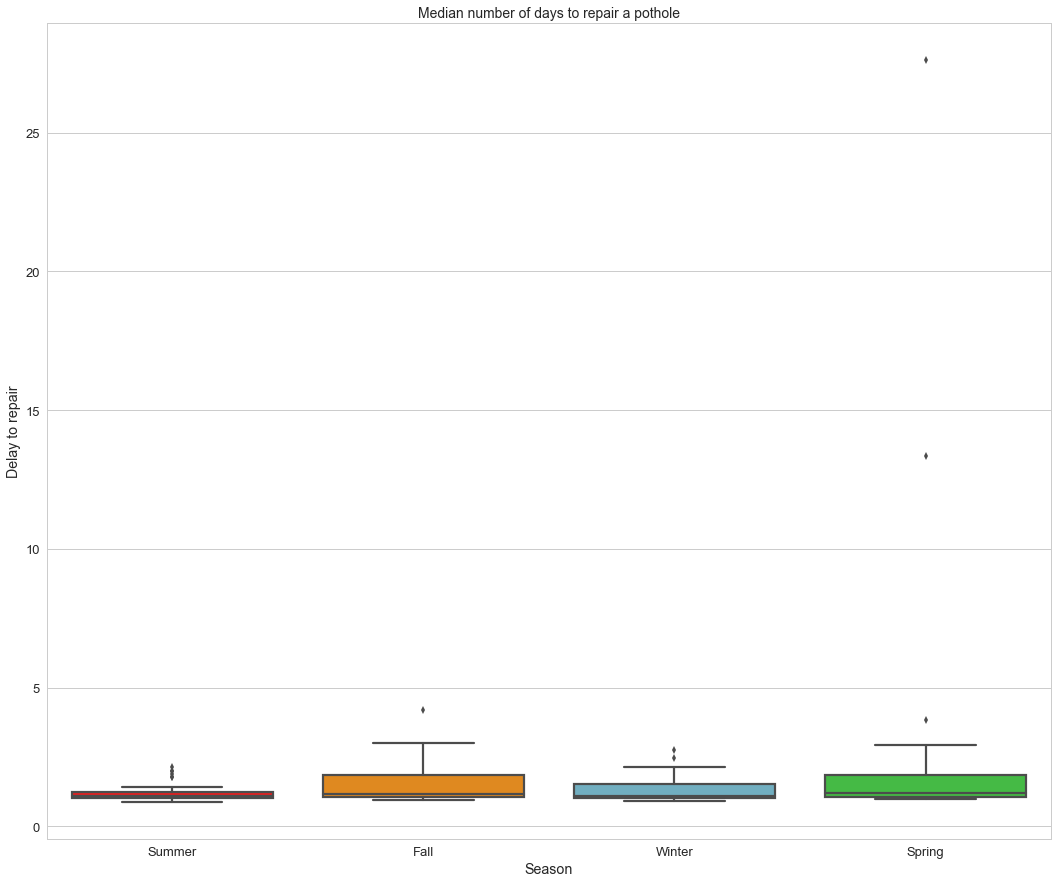

In [203]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.2})
fig, ax = plt.subplots(figsize=(18,15))
sns.boxplot(x='Season',y="time_repair",
            data=yearly_repair_time_df,
            palette = sns.color_palette(['red','darkorange','c','limegreen']))
ax.set(xlabel="Season",ylabel='Delay to repair')
plt.title('Median number of days to repair a pothole', fontsize=14);

With only a few outliers and a median time of 2 days to fix a pothole, the city has a good response time. Moreover, the response time barely varies from one season to the other, which indicates that the city responds well to pothole claims even during the winter.

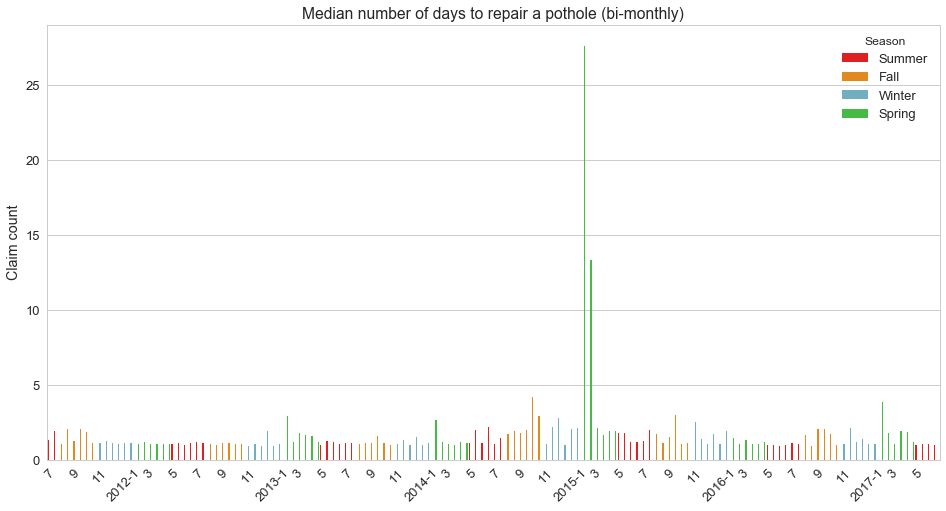

In [204]:
# Set main plot parameters
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.2})

# Create x labels using list comprehension
yearly_claim_df.index = pd.to_datetime(yearly_claim_df.index)
x_label = [str(x.year)+"-"+str(x.month) if x.day==1 and x.month==1 else
           (x.month) if x.day==1 and x.month%2==1 else '' for x in yearly_claim_df.index]

# Plot
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.barplot(x=yearly_repair_time_df.index,
            y=yearly_repair_time_df.time_repair,hue=yearly_claim_df.Season,
           palette = sns.color_palette(['red','darkorange','c','limegreen']))

# Set plot labels
ax.set_title("Median number of days to repair a pothole (bi-monthly)")
ax.set(xlabel="",ylabel='Claim count')
ax.set_xticklabels(x_label,rotation=45)

plt.show()

Obviously, the first month of the spring of 2015 is an outlier. Let's investigate why the time to repair was so long. Before looking at the data for this specific month, we can make an hypothsis, this increase in time repair is probably due to the snow falls. Indeed, New England experienced the worst winter in decades. The accumulation of snow, the long lasting freezing temperatures prevented the city to fix the potholes.

In [205]:
claims_feb_2015_df=potholes_df[(potholes_df.OPEN_DT>datetime.date(2015,2,1)) & (potholes_df.OPEN_DT<datetime.date(2015,3,1)) & (potholes_df.time_repair>0.5)]
claims_feb_2014_df=potholes_df[(potholes_df.OPEN_DT>datetime.date(2014,2,1)) & (potholes_df.OPEN_DT<datetime.date(2014,3,1)) & (potholes_df.time_repair>0.5)]


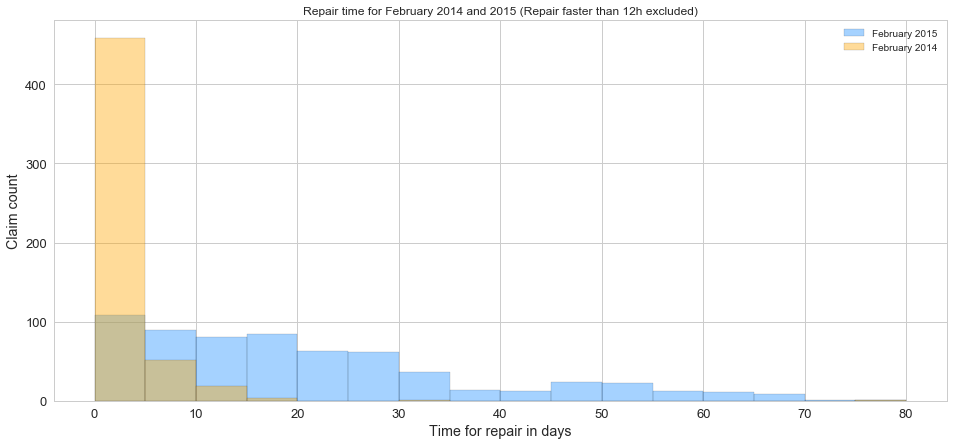

In [206]:
# Set main plot parameters
fig, ax = plt.subplots(figsize=(16,7))
sns.set_style("whitegrid")

sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.distplot(claims_feb_2015_df.time_repair,
             kde=False,hist_kws=dict(edgecolor="black"),color='dodgerblue',
            bins = np.linspace(0, 80, 17),label="February 2015")
sns.distplot(claims_feb_2014_df.time_repair,
             kde=False,hist_kws=dict(edgecolor="black"),color='orange',
            bins = np.linspace(0, 80, 17),label="February 2014")

ax.legend()

# Set plot labels
ax.set_title("Repair time for February 2014 and 2015 (Repair faster than 12h excluded)")
ax.set(xlabel="Time for repair in days",ylabel='Claim count');

As shown above, the distribution of the repair time over the month of February 2015 is spread from 0 to 80 days with a linear decreasse. The data for the month of February 2014 is mostly contained in the 0 to 5 days bin. There are two factors that can explain the difference:
 1. The city workers in 2015 were also allocated to snow removale therefore the number of team available to repair pothole was less than that of 2014.
 2. Because of the expected heavy snowfall, the city waited for the multiple storms to end and started fixing pothole once the bad weather was over.

Just like we did for the monthly number of claims, we will evaluate the impact of the weather on the repair delay.

## 2.4 Temperature and snow/rain effects on the repair time

In [207]:
# Prepare dataframe
yearly_repair_time_df = potholes_df[['OPEN_DT','time_repair','CASE_ENQUIRY_ID']].copy()
yearly_repair_time_df = yearly_repair_time_df[yearly_repair_time_df.time_repair>=0.5]
yearly_repair_time_df.OPEN_DT = yearly_repair_time_df.OPEN_DT.apply(lambda x: x.replace(day=1)).dt.date

# Filter the month of february 2015
yearly_repair_time_df = yearly_repair_time_df[yearly_repair_time_df.OPEN_DT!=datetime.date(2015,2,1)]

# Add season for visual inspection
season_dict = {
    1: 'Winter',
    2: 'Spring',
    3: 'Spring',
    4: 'Spring',
    5: 'Summer',
    6: 'Summer',
    7: 'Summer',
    8: 'Fall',
    9: 'Fall',
    10: 'Fall',
    11: 'Winter',
    12: 'Winter',
}

# We create the season feature
yearly_repair_time_df['Season'] = yearly_repair_time_df.OPEN_DT.map(lambda x: season_dict[x.month])
yearly_repair_time_df = yearly_repair_time_df.groupby('OPEN_DT').median()

# Weather data
#weather_repair_df = weather_df.loc[:,['DSNW','DT32','TAVG',"DP10"]]
weather_repair_df = weather_df.copy()

# Merge pothole and weather data
yearly_repair_time_df = yearly_repair_time_df.merge(right=weather_repair_df,how='left',left_index=True,right_index=True)
yearly_repair_time_df.tail()

time_repair  CASE_ENQUIRY_ID  CDSD  CLDD  DP01  DP10  DSNW  DT00  \
OPEN_DT                                                                        
2017-02-01     1.983466     1.010020e+11     0     0    10     6     6     0   
2017-03-01     1.751892     1.010020e+11     0     0    13     5     2     0   
2017-04-01     1.789896     1.010021e+11    18    18    12     6     1     0   
2017-05-01     0.994479     1.010021e+11    59    41    14     7     0     0   
2017-06-01     1.005943     1.010021e+11   245   186    14     7     0     0   

            DT32  DX32  ...   EMSN  EMXP  EMXT  HDSD  HTDD  PRCP  SNOW  TAVG  \
OPEN_DT                 ...                                                    
2017-02-01    20     2  ...   10.9  1.25    73  3571   793  3.22  21.5  36.7   
2017-03-01    21     5  ...    6.6  1.62    63  4529   959  4.18  10.1  34.1   
2017-04-01     0     0  ...    1.2  1.56    86  4946   417  5.74   1.2  51.7   
2017-05-01     0     0  ...    0.0  0.95    95  5256   310  3.45   0.0  56.3   
2017-06-01     0     0  ...    0.0  2.13    95  5308    52  4.85   0.0  69.5   

            TMAX  TMIN  
OPEN_DT                 
2017-02-01  44.7  28.6  
2017-03-01  41.4  26.7  
2017-04-01  59.8  43.5  
2017-05-01  62.5  50.1  
2017-06-01  78.4  60.5  

[5 rows x 23 columns]

In [208]:
# Compute correlation matrix and trim the unecessary values
correlation = yearly_repair_time_df.corr()
correlation=correlation.loc[correlation.columns.str.contains('time_repair'),~correlation.index.str.contains('time_repair')]
correlation

CASE_ENQUIRY_ID      CDSD      CLDD      DP01      DP10  \
time_repair         0.171343  0.052018 -0.018968 -0.017158 -0.022928   

                 DSNW      DT00      DT32      DX32      DX70    ...     \
time_repair  0.121802  0.040156 -0.025066 -0.031341  0.037396    ...      

                 EMSN      EMXP      EMXT      HDSD      HTDD      PRCP  \
time_repair  0.132492  0.119879  0.028873 -0.106695 -0.044099  0.028406   

                 SNOW      TAVG      TMAX      TMIN  
time_repair  0.125716  0.030337  0.028787  0.030914  

[1 rows x 22 columns]

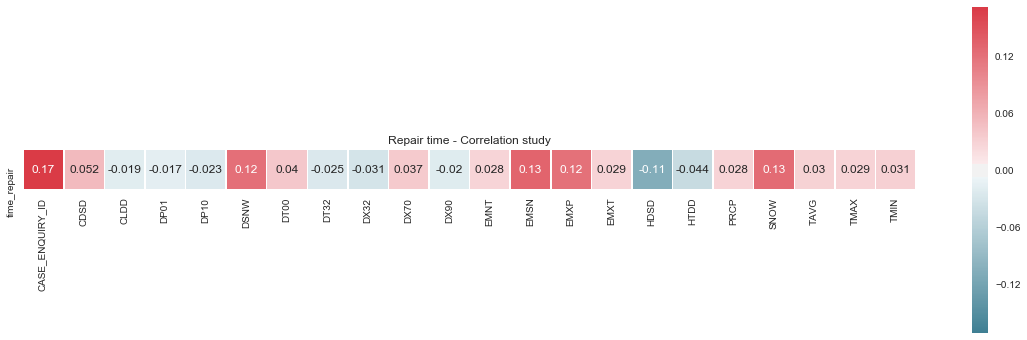

In [209]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = plt.axes()
sns.heatmap(correlation, cmap=cmap,square=True, linewidths=.5,annot=True,annot_kws={"size":12})
ax.set_title("Repair time - Correlation study");

As shown above, there is no clear correlation between the weather data and the repair time. This confirms that except a few outliers, the city has a fast and consistent response when it comes to fixing potholes reported though 3-1-1 calls.

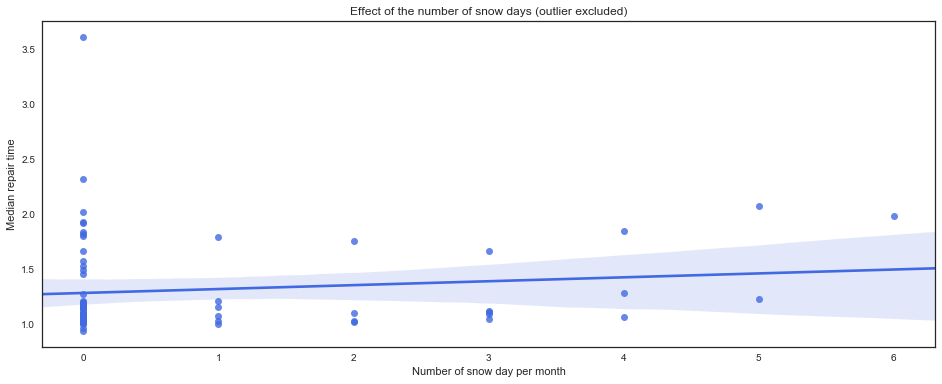

In [210]:
fig, ax = plt.subplots(figsize=(16,6))
sns.regplot(x='DSNW',y="time_repair",data=yearly_repair_time_df,color="royalblue")
ax.set_title("Effect of the number of snow days (outlier excluded)")
ax.set(xlabel="Number of snow day per month",ylabel='Median repair time');

There is no clear correlation between the number of snow days and the time to repair a pothole.

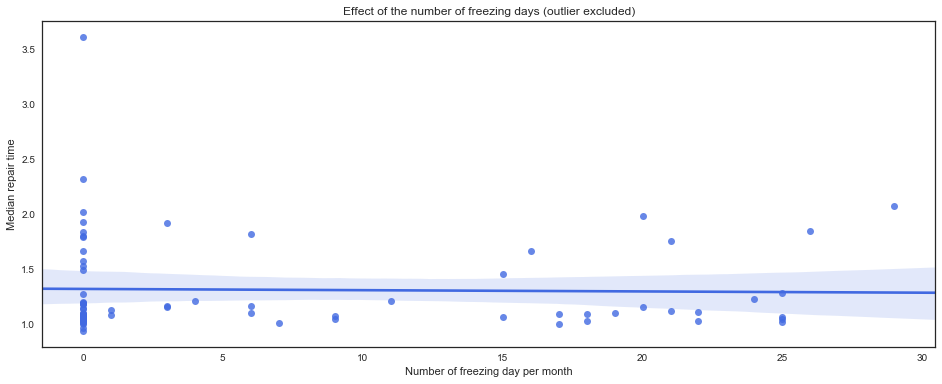

In [211]:
fig, ax = plt.subplots(figsize=(16,6))
sns.regplot(x='DT32',y="time_repair",data=yearly_repair_time_df,color="royalblue")
ax.set_title("Effect of the number of freezing days (outlier excluded)")
ax.set(xlabel="Number of freezing day per month",ylabel='Median repair time');

There is no clear correlation between the number of freezing day and the time to repair a pothole.

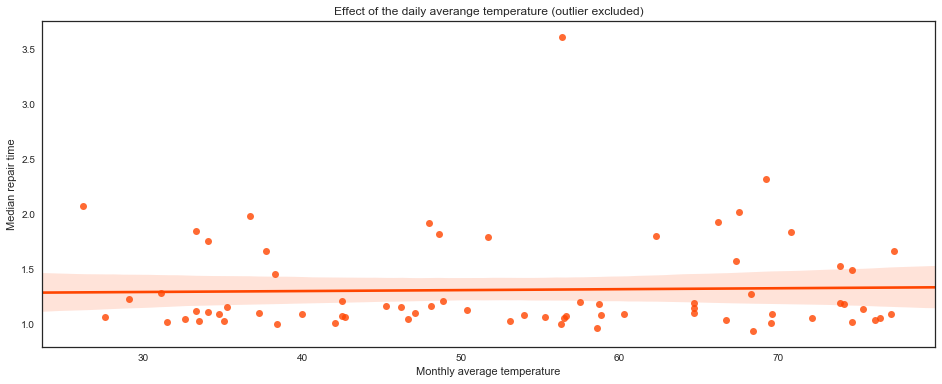

In [212]:
fig, ax = plt.subplots(figsize=(16,6))
sns.regplot(x='TAVG',y="time_repair",data=yearly_repair_time_df,color="orangered")
ax.set_title("Effect of the daily averange temperature (outlier excluded)")
ax.set(xlabel="Monthly average temperature",ylabel='Median repair time');

There is no clear correlation between the average temperature and the time to repair a pothole.

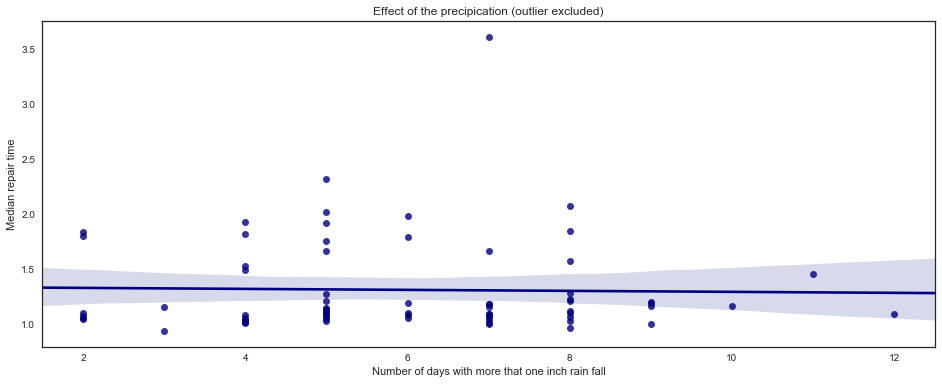

In [213]:
fig, ax = plt.subplots(figsize=(16,6))
sns.regplot(x='DP10',y="time_repair",data=yearly_repair_time_df,color="navy")
ax.set_title("Effect of the precipication (outlier excluded)")
ax.set(xlabel="Number of days with more that one inch rain fall",ylabel='Median repair time');

There is no clear correlation between the number of rainy days and the time to repair a pothole.

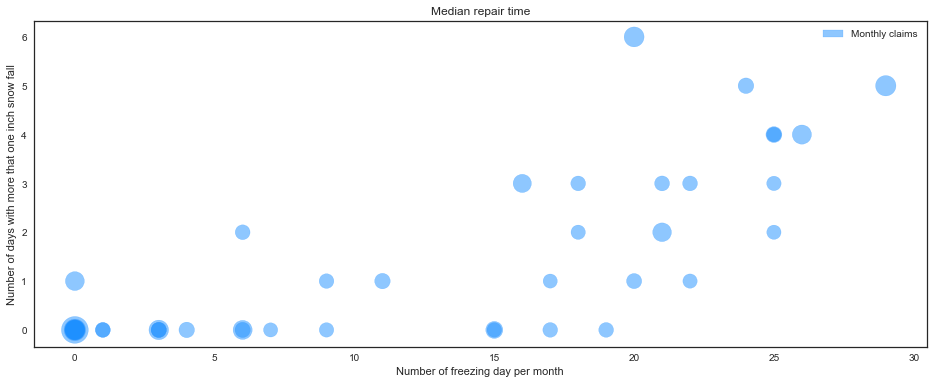

In [214]:
# Scatter plot of the monthly number of claims as a function of the snowfall and freezing days
fig, ax = plt.subplots(figsize=(16,6))
plt.scatter(x=yearly_repair_time_df['DT32'],
            y=yearly_repair_time_df['DSNW'],
            s=yearly_repair_time_df['time_repair']*200,
            c = 'dodgerblue',alpha = 0.5)
ax.set_title("Median repair time")
ax.set(xlabel="Number of freezing day per month",ylabel='Number of days with more that one inch snow fall');

plt.legend(handles=[mpatches.Patch(color='dodgerblue', alpha=0.5,label='Monthly claims')]);

Again, there is no clear correlation. In conclusion, it seems that the repair time is not impacted by the weather conditions.

# 3. Number of claims vs. time for repair

In this section, we will investigate if the time to repair a pothole and the number of claims are correlated. We will be working using monthly periods.

In [215]:
# Prepare dataframe
repair_vs_count_df = potholes_df[['OPEN_DT','time_repair','CASE_ENQUIRY_ID']].copy()
repair_vs_count_df = repair_vs_count_df[repair_vs_count_df.time_repair>=0.5]

# Re-adjust the OPEN_DT to the first day of the month
repair_vs_count_df.OPEN_DT = repair_vs_count_df.OPEN_DT.apply(lambda x: x.replace(day=1)).dt.date

# Filter the month of february 2015
repair_vs_count_df = repair_vs_count_df[repair_vs_count_df.OPEN_DT!=datetime.date(2015,2,1)]

repair_vs_count_df = repair_vs_count_df.groupby('OPEN_DT').agg({'time_repair':['median'], 'CASE_ENQUIRY_ID':['count']})

repair_vs_count_df.head()

time_repair CASE_ENQUIRY_ID
                median           count
OPEN_DT                               
2011-07-01    1.660625             147
2011-08-01    1.192743             140
2011-09-01    1.567940              98
2011-10-01    1.194236             169
2011-11-01    1.123142             160

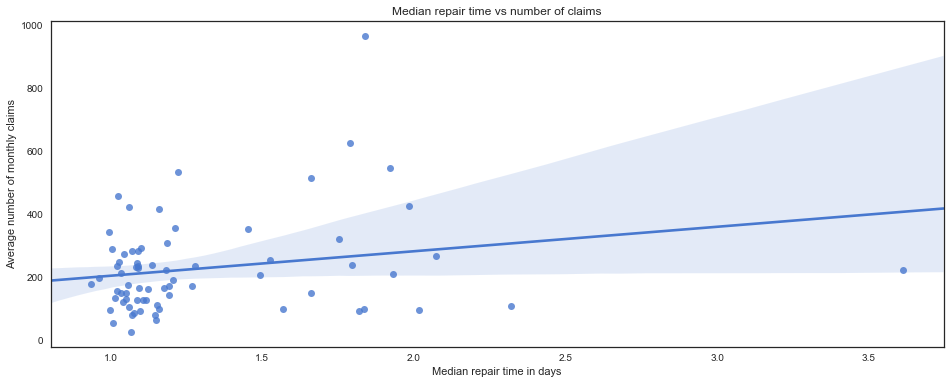

In [216]:
# Scatter plot of the monthly number of claims as a function of the snowfall and freezing days
fig, ax = plt.subplots(figsize=(16,6))
sns.regplot(x=repair_vs_count_df[('time_repair', 'median')],
            y=repair_vs_count_df[('CASE_ENQUIRY_ID', 'count')])
ax.set_title("Median repair time vs number of claims")
ax.set(xlabel="Median repair time in days",ylabel='Average number of monthly claims');

In [217]:
repair_vs_count_df.corr()

time_repair CASE_ENQUIRY_ID
                            median           count
time_repair     median    1.000000        0.218533
CASE_ENQUIRY_ID count     0.218533        1.000000

As shown above, there is no clear positive correlation (0.21) between the two features.

# 4. Intersections 

In [218]:
# Prepare dataframe
intersection_df = potholes_df[['CASE_ENQUIRY_ID','is_intersection']].copy()

In [219]:
intersection_df = intersection_df.groupby('is_intersection').count()
intersection_df

CASE_ENQUIRY_ID
is_intersection                 
False                      23344
True                       12090

As shown above, the number of potholes located within intersection is extremely high compared to the proportion of road that constitutes intersections. This can be explained by the failure mechanism of the top layer of the road. Indeed the asphalt works well in compression but is not as good to support shear loads which happen when a car changes direction.
If we conservatively assume that intersection accounts for 10% of the roads in the city, while they account for ~33% of the pothole claims.

# 5. Population

In this section, we will investigate if the number of claims is correlated with the number of people living in a neighborhood but also with the neighborhood area.

In [220]:
# Prepare dataframe
pop_claim_df = potholes_df[['CASE_ENQUIRY_ID','time_repair','LOCATION_ZIPCODE']].copy()
pop_claim_df = pop_claim_df[pop_claim_df.time_repair>=0.5]

# The data is grouped
pop_claim_df = pop_claim_df.groupby('LOCATION_ZIPCODE').agg({'time_repair':['median'], 'CASE_ENQUIRY_ID':['count']})

# Merge pothole and city data
pop_claim_df = pop_claim_df.merge(right=boston_zip_df,how='left',left_index=True,right_index=True)
pop_claim_df.tail()

/Users/thibault.dody/anaconda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


(time_repair, median)  (CASE_ENQUIRY_ID, count)  \
LOCATION_ZIPCODE                                                    
2163.0                         1.006100                        15   
2199.0                         1.956597                        62   
2210.0                         1.599028                       222   
2215.0                         1.049155                       472   
2467.0                         1.471690                        12   

                    population  population_density  area_acres   Latitude  \
LOCATION_ZIPCODE                                                            
2163.0             1191.000000             8842.92   86.197772  42.366168   
2199.0             1005.000000            17390.25   36.986242  42.347465   
2210.0              592.000000              757.88  499.920832  42.347682   
2215.0            21963.000000            25125.73  559.439268  42.347053   
2467.0             3054.847213             4896.38    0.623899  42.322089   

                  Longitude  area_sqmiles  
LOCATION_ZIPCODE                           
2163.0           -71.122850      0.134684  
2199.0           -71.082058      0.057791  
2210.0           -71.041731      0.781126  
2215.0           -71.101985      0.874124  
2467.0           -71.172760      2.262488

In [221]:
# Compute correlation matrix and trim the unecessary values
correlation = pop_claim_df.corr()
correlation=correlation.loc[[('time_repair','median'),('CASE_ENQUIRY_ID','count')],
                            ~correlation.columns.isin([('CASE_ENQUIRY_ID','count'),('time_repair','median'),'Latitude','Longitude'])]
correlation

population  population_density  area_acres  \
(time_repair, median)      -0.311371            0.235571   -0.313846   
(CASE_ENQUIRY_ID, count)    0.637719            0.098370    0.420059   

                          area_sqmiles  
(time_repair, median)        -0.311744  
(CASE_ENQUIRY_ID, count)      0.340869

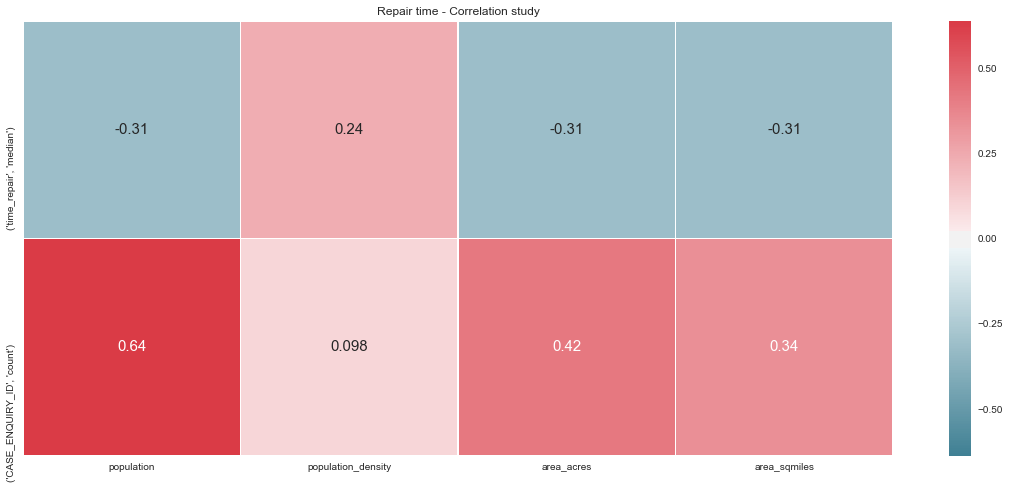

In [222]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = plt.axes()
sns.heatmap(correlation, cmap=cmap,square=True, linewidths=.5,annot=True,annot_kws={"size":15})
ax.set_title("Repair time - Correlation study");

The correlation study shows the following relationships:
 1. The number of claims and the repair time are not correlated (-0.068)
 2. The number of claims and the population density are slightly positively correlated (0.24)
 3. Surprisingly, the number of claims is slightly negatively correlated with the population size and the neighborhood area. This is unexpreded as common sense would tell you that bigger neighborhood would be less organized and that the repair time would be longer. In fact, the opposite conclusion stands.
 4. As expected, the number of claims is positively correlated with the population size (0.64)

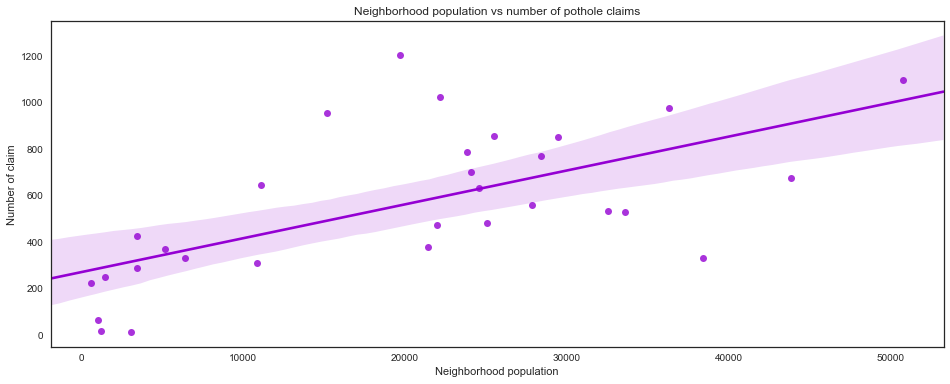

In [223]:
fig, ax = plt.subplots(figsize=(16,6))
sns.regplot(x=pop_claim_df['population'],y=pop_claim_df[("CASE_ENQUIRY_ID", "count")],color="darkviolet")
ax.set_title("Neighborhood population vs number of pothole claims")
ax.set(xlabel="Neighborhood population",ylabel='Number of claim');

The correlation of the above plot is 0.64. Since the population count is positively correlated with the area of the zip code, the number of pothole claims is correlated with the neighborhood area. The plot below summarises the correlation between the population density and the number of claims.

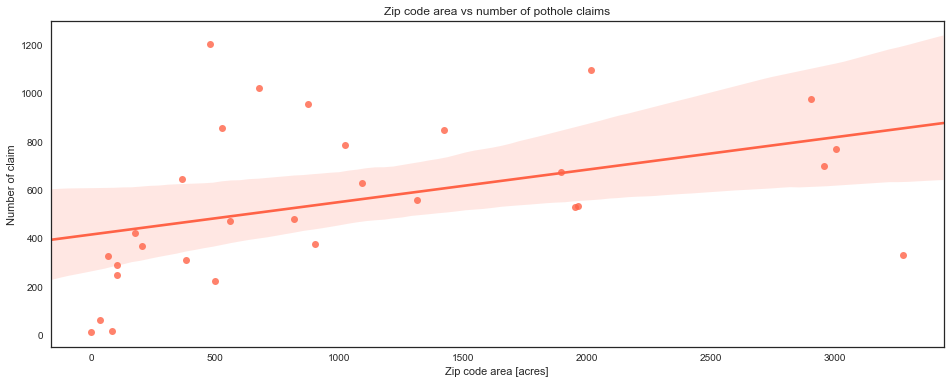

In [224]:
fig, ax = plt.subplots(figsize=(16,6))
sns.regplot(x=pop_claim_df['area_acres'],y=pop_claim_df[("CASE_ENQUIRY_ID", "count")],color="tomato")
ax.set_title("Zip code area vs number of pothole claims")
ax.set(xlabel="Zip code area [acres]",ylabel='Number of claim');

In the above plot, the correlation factor is 0.42.

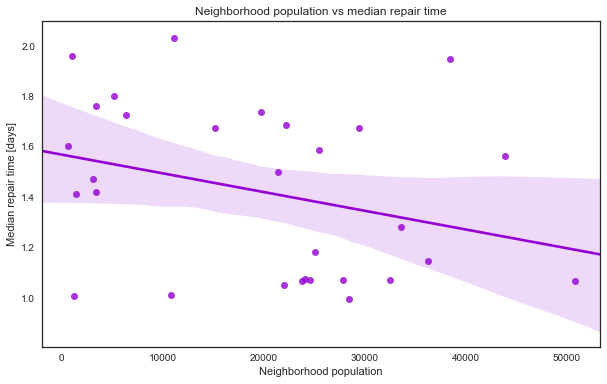

In [225]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x=pop_claim_df['population'],y=pop_claim_df[("time_repair", "median")],color="darkviolet")
ax.set_title("Neighborhood population vs median repair time")
ax.set(xlabel="Neighborhood population",ylabel='Median repair time [days]');

Interestingly, while the data presented in the plot above is well spread around the regression line, we can see that there is a negative correlation (-0.31) between the population size and the median repair time.

# 6. Claim distribution per neighborhood

In this section, we will try to understand if more potholes claimed are reported in certain neighborhoods. We will normalize the data by dividing the number of claims by 100 inhabitants.

In [226]:
# Create a data frame that contains the number of claim per year per zip code
claim_per_zip_df = potholes_df.copy()
claim_per_zip_df.LOCATION_ZIPCODE=claim_per_zip_df.LOCATION_ZIPCODE.astype(int)

claim_per_zip_df = claim_per_zip_df[['CASE_ENQUIRY_ID','LOCATION_ZIPCODE']].groupby('LOCATION_ZIPCODE').count()

In [227]:
# Merge the claim_per_zip_df with the boston_zip_df in order to normalize the number of cases per 100 people
claim_per_zip_df = claim_per_zip_df.merge(boston_zip_df,
                                          left_index=True,
                                          right_index=True,
                                          how='left')
claim_per_zip_df.reset_index(drop=False,inplace=True)

# Create the new feature
claim_per_zip_df['pothole_density'] = claim_per_zip_df['CASE_ENQUIRY_ID']/claim_per_zip_df['population']*100

claim_per_zip_df.LOCATION_ZIPCODE  = "0"+claim_per_zip_df.LOCATION_ZIPCODE.astype(str)

claim_per_zip_df.head()

LOCATION_ZIPCODE  CASE_ENQUIRY_ID  population  population_density  \
0            02108              769      3446.0            12377.16   
1            02109              442      3428.0            20752.98   
2            02110              405      1428.0             8630.93   
3            02111              510      5138.0            15967.11   
4            02113              489      6401.0            60728.26   

   area_acres   Latitude  Longitude  area_sqmiles  pothole_density  
0  178.186272  42.357554 -71.063913      0.278416        22.315728  
1  105.715902  42.362653 -71.053804      0.165181        12.893816  
2  105.888937  42.357371 -71.053180      0.165451        28.361345  
3  205.943342  42.348784 -71.058988      0.321786         9.926041  
4   67.458544  42.365170 -71.055363      0.105404         7.639431

In order to adapt the density plot to the range of values, we first identify the quantiles of the distribution.

In [228]:
claim_per_zip_df.pothole_density.describe()

count    30.000000
mean      9.263844
std      10.071021
min       1.080250
25%       4.558071
50%       7.157011
75%       9.247936
max      53.716216
Name: pothole_density, dtype: float64

Upon review of the values presented above, it seems that the data is skewed. Several of the records (potential outliers) have a high pothole claim number to population ratio.

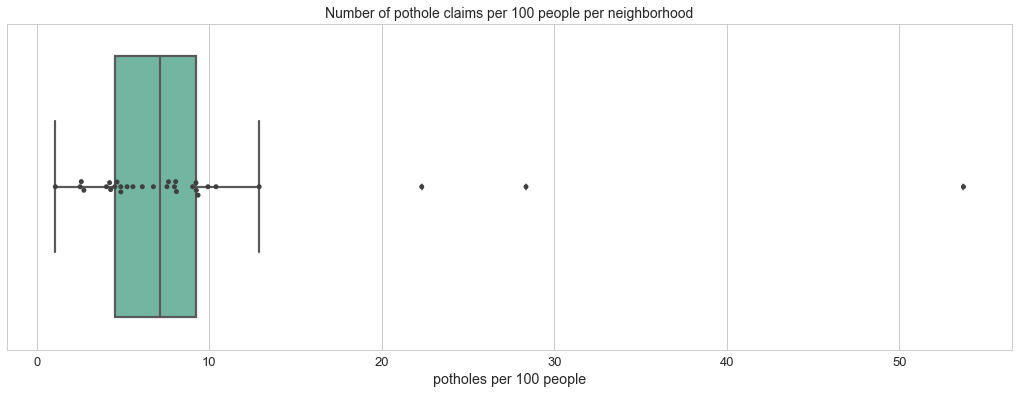

In [229]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.2})
fig, ax = plt.subplots(figsize=(18,6))
sns.boxplot(x='pothole_density',
            data=claim_per_zip_df,
            palette="Set2")
sns.swarmplot(x='pothole_density',
            data=claim_per_zip_df,
            color=".25")
ax.set(xlabel="potholes per 100 people")
plt.title('Number of pothole claims per 100 people per neighborhood', fontsize=14);

Per the boxplot shown above, it seems that three zipcodes have a much higher ratio that the other. In order to draw a conclusion, we will now plot the results on a map.

In [230]:
# Create map object, set location and zoom
map_density = folium.Map(location=[42.357554, -71.063913],zoom_start=11)

threshold_scale = [3,5,7,10,20,50]


map_density.choropleth(geo_path='./Original Data/Map per zip/Zip_Codes.json',
                       data = claim_per_zip_df,
                       columns=['LOCATION_ZIPCODE','pothole_density'],
                       key_on='feature.properties.ZIP5',
                       fill_color='YlOrRd',
                       threshold_scale=threshold_scale,
                       legend_name = "Pothole claims per 100 inhabitants")

map_density

In [231]:
#List of the three outliers
claim_per_zip_df.sort_values(by='pothole_density',ascending=False).head(5)

LOCATION_ZIPCODE  CASE_ENQUIRY_ID  population  population_density  \
27            02210              318       592.0              757.88   
2             02110              405      1428.0             8630.93   
0             02108              769      3446.0            12377.16   
1             02109              442      3428.0            20752.98   
24            02136             2951     28392.0             6048.39   

     area_acres   Latitude  Longitude  area_sqmiles  pothole_density  
27   499.920832  42.347682 -71.041731      0.781126        53.716216  
2    105.888937  42.357371 -71.053180      0.165451        28.361345  
0    178.186272  42.357554 -71.063913      0.278416        22.315728  
1    105.715902  42.362653 -71.053804      0.165181        12.893816  
24  3004.250718  42.255083 -71.129220      4.694142        10.393773

Now that we have targeted the outliers, the goal is to understand why they have such a high ration.
First, we will investigate their population density. Indeed, if a neighborhood does not have manny people living in but many working in, the roads will be subjected to high traffic while the population count would remain low. The first feature they have in common is their locations, all three are located in the center of the financial district. These neighborhoods are known for their old, narrow streets.

In [232]:
boston_zip_df[boston_zip_df.index.isin(claim_per_zip_df.sort_values(by='pothole_density',ascending=False).head(3).LOCATION_ZIPCODE.values)]

population  population_density  area_acres   Latitude  Longitude  \
zipcode                                                                     
2108         3446.0            12377.16  178.186272  42.357554 -71.063913   
2110         1428.0             8630.93  105.888937  42.357371 -71.053180   
2210          592.0              757.88  499.920832  42.347682 -71.041731   

         area_sqmiles  
zipcode                
2108         0.278416  
2110         0.165451  
2210         0.781126

In [233]:
boston_zip_df.population_density.sort_values(ascending=False)

zipcode
2113    60728.260000
2115    30823.240000
2116    26352.260000
2215    25125.730000
2118    20902.060000
2109    20752.980000
2121    19592.250000
2114    19357.550994
2120    18116.780000
2199    17390.250000
2124    16127.900000
2111    15967.110000
2134    15139.350000
2119    14856.360000
2135    14809.880000
2122    14350.840000
2126    13523.150000
2127    13233.610000
2108    12377.160000
2129    11130.850000
2125    11016.970000
2131    10592.040000
2163     8842.920000
2110     8630.930000
2130     7993.430000
2128     7504.840000
2136     6048.390000
2132     5203.600000
2467     4896.380000
2210      757.880000
Name: population_density, dtype: float64

Based on the population density ranking, zip code 02210 and 02110 appear to be located in the bottom half of the table in term of population density. In conclusion, while having fewer people living in these areas, these two neighborhoods are located at the intersection of the South of Boston and the cities of Cambridge and Somerville (both located North of the Charles river).

We saw that discrepancies appear when comparing the number of claims per neighborhoods. We will now refine the study of the number of claims distribution by looking at a finer mesh. The size of the mesh is based on the range of latitude and longitude of the pothole claims.

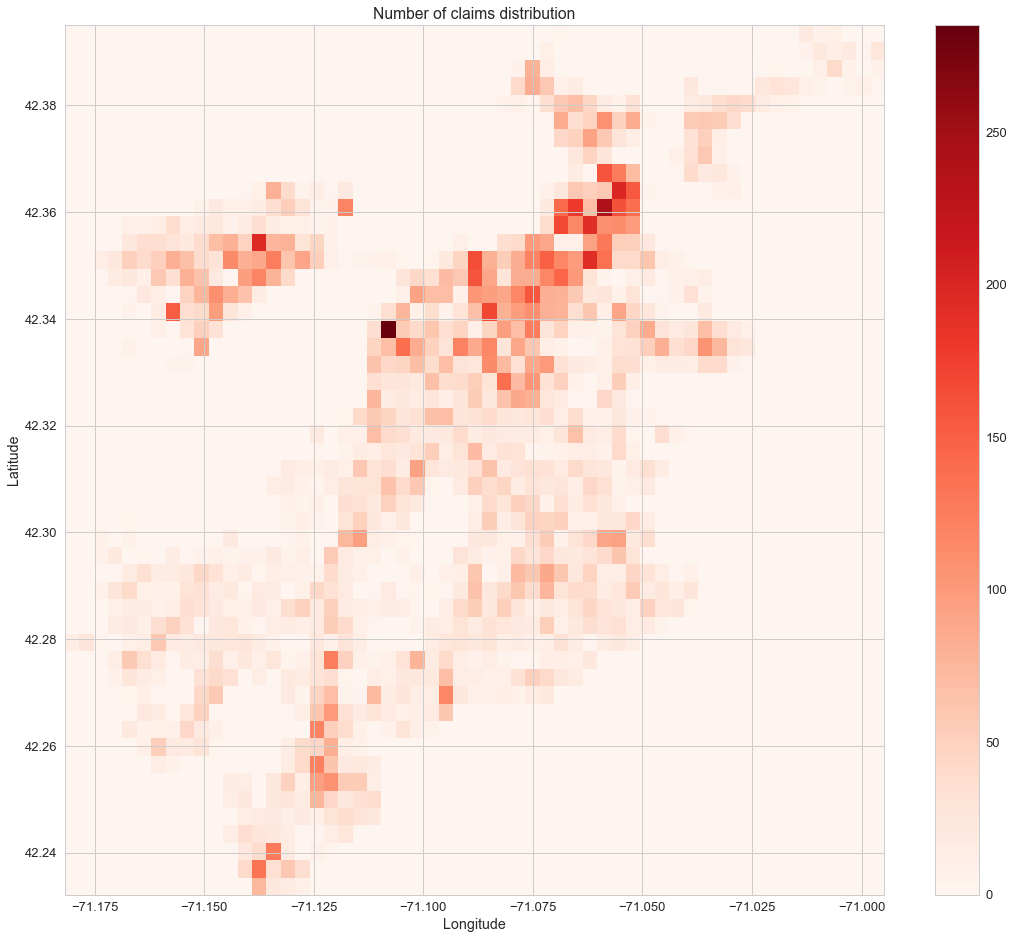

In [234]:
fig, ax = plt.subplots(figsize=(16*1.1469,16))
plt.hist2d(x=potholes_df['LONGITUDE'],y=potholes_df['LATITUDE'],bins=(50*1.1469,50),cmap='Reds')
plt.colorbar()
ax.set_title("Number of claims distribution")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

As show above, they are several location with a high number of claims. They correspond to the West Boston area and the city historical center.

# 7. Time for repair per neighborhood

In this section, we will try to understand if more the repair delay varies between areas.

In [235]:
# Create a data frame that contains the number of claim per year per zip code
repair_time_zip_df = potholes_df.copy()
repair_time_zip_df.LOCATION_ZIPCODE=repair_time_zip_df.LOCATION_ZIPCODE.astype(int)

# As previously explained, we will focus on repair that took more that 12h to occur
repair_time_zip_df = repair_time_zip_df[repair_time_zip_df.time_repair>=0.5]

# Normalize the zip code feature repair_time_zip_df
repair_time_zip_df.LOCATION_ZIPCODE  = "0"+repair_time_zip_df.LOCATION_ZIPCODE.astype(str)

repair_time_zip_df = repair_time_zip_df[['time_repair','LOCATION_ZIPCODE']].groupby('LOCATION_ZIPCODE').median()

repair_time_zip_df.reset_index(drop=False,inplace=True)

repair_time_zip_df.head()

LOCATION_ZIPCODE  time_repair
0            02108     1.761377
1            02109     1.419774
2            02110     1.408796
3            02111     1.798194
4            02113     1.723513

In [236]:
repair_time_zip_df.time_repair.describe()

count    30.000000
mean      1.420162
std       0.333522
min       0.995648
25%       1.069204
50%       1.445732
75%       1.682211
max       2.028819
Name: time_repair, dtype: float64

This time, the distribution seems a lot less spread.

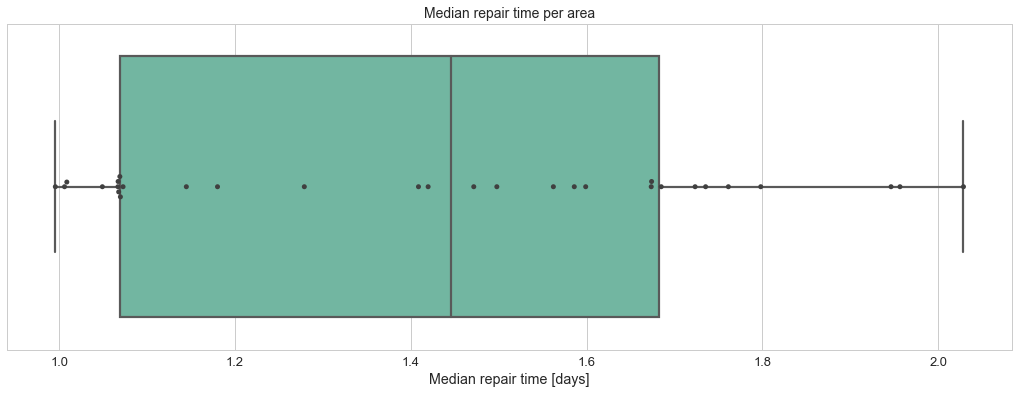

In [237]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.2})
fig, ax = plt.subplots(figsize=(18,6))
sns.boxplot(x='time_repair',
            data=repair_time_zip_df,
            palette="Set2")
sns.swarmplot(x='time_repair',
            data=repair_time_zip_df,
            color=".25")
ax.set(xlabel="Median repair time [days]")
plt.title('Median repair time per area', fontsize=14);

In [238]:
# Create map object, set location and zoom
map_repair = folium.Map(location=[42.357554, -71.063913],zoom_start=11)

threshold_scale = [1,1.22,1.4,1.6,1.8,2]

map_repair.choropleth(geo_path='./Original Data/Map per zip/Zip_Codes.json',
                       data = repair_time_zip_df,
                       columns=['LOCATION_ZIPCODE','time_repair'],
                       key_on='feature.properties.ZIP5',
                       fill_color='YlOrRd',
                       threshold_scale=threshold_scale,
                       legend_name = "Pothole claims per 100 inhabitants")

map_repair

In [239]:
repair_time_zip_df.sort_values('time_repair')

LOCATION_ZIPCODE  time_repair
24            02136     0.995648
25            02163     1.006100
10            02120     1.008704
28            02215     1.049155
9             02119     1.066875
13            02124     1.067060
15            02126     1.067726
12            02122     1.069051
20            02131     1.069664
21            02132     1.072674
19            02130     1.144687
11            02121     1.180150
14            02125     1.278912
2             02110     1.408796
1             02109     1.419774
29            02467     1.471690
22            02134     1.497940
23            02135     1.562269
6             02115     1.586047
27            02210     1.599028
16            02127     1.673588
18            02129     1.673981
8             02118     1.684954
4             02113     1.723513
7             02116     1.735463
0             02108     1.761377
3             02111     1.798194
17            02128     1.946418
26            02199     1.956597
5             02114     2.028819

We already stated that the data range is small but the map above shows a clear split between the northen most areas and the shouthern most ones. We will try to understand this trend by plotting the population density on a map.

In [240]:
# Create map object, set location and zoom
map_pop_density = folium.Map(location=[42.357554, -71.063913],zoom_start=11)

claim_per_zip_df.population_density=claim_per_zip_df.population_density.divide(1000)

threshold_scale = [claim_per_zip_df.population_density.quantile(0.20),
                  claim_per_zip_df.population_density.quantile(0.40),
                  claim_per_zip_df.population_density.quantile(0.60),
                  claim_per_zip_df.population_density.quantile(0.80),
                  claim_per_zip_df.population_density.quantile(1.00)]

map_pop_density.choropleth(geo_path='./Original Data/Map per zip/Zip_Codes.json',
                       data = claim_per_zip_df,
                       columns=['LOCATION_ZIPCODE','population_density'],
                       key_on='feature.properties.ZIP5',
                       fill_color='BuPu',
                       legend_name = "Population density (in thousands)",
                       threshold_scale=threshold_scale)

map_pop_density

The map shown above depicts the population density per neighborhood. As we can see, there is a higher population density for the neighborhoods located near the heart of Boston. However, the study of the population density is not enough to explain the discrepancy between the repair delay. The delay to fix the potholes is probably more related to the organization of the Department of Transportation and how its teams are assigned to districts.

We saw that discrepancies appear when comparing the median repair per neighborhoods. We will now refine the study of the number of claims distribution by looking at a finer mesh. The size of the mesh is based on the range of latitude and longitude of the pothole claims.

# 8. Specific case study

Performing a detailed case study of all the neighborhood is not convenient and would not provide a good insight. We will choose 3 neighborhoods based on the study done so far. The seclected neighborhoods are the followings:
- 02114: Longest time repair
- 02210: Largest number of potholes per 100 people
- 02113: Largest population density

In [241]:
selected_zip = ['02114','02210','02113']

In [242]:
# List comprehension to ontain the coordinates of the missing locations as list of lists.
selected_zip_df = potholes_df[potholes_df.LOCATION_ZIPCODE.isin(selected_zip)] 
selected_zip_map = [[x,y] for x,y in 
                         zip(selected_zip_df.LATITUDE.values,selected_zip_df.LONGITUDE.values)]

# Create map object
selected_zip_map = folium.Map(location=[42.357554, -71.063913],zoom_start=12)

# Create markers and plot map
    
selected_zip_map.add_child(folium.GeoJson(data=open('./Original Data/Map per zip/map.geojson'),
                    name='Zip codes',
                    style_function=lambda x: {'fillColor':'red' if x['properties']['ZIP5'] in selected_zip
                                                                else 'white','fillOpacity' : 0.5,'weight' : 1,'color':'black'}))

selected_zip_map

We extract the data for these zip codes and look at the variation of the number of claims and repair time during the years.

In [243]:
# Filtered the data to only cover the selected zipcodes
filtered_potholes_df = potholes_df[potholes_df.LOCATION_ZIPCODE.isin(selected_zip)][['OPEN_DT','CASE_ENQUIRY_ID','LOCATION_ZIPCODE']]

# Set all the dates to the first of the month
filtered_potholes_df.OPEN_DT = filtered_potholes_df.OPEN_DT.apply(lambda x: x.replace(day=1)).dt.date

# Group by date and zip code
filtered_potholes_df = filtered_potholes_df.groupby(['OPEN_DT','LOCATION_ZIPCODE']).count()

filtered_potholes_df.reset_index(drop=False,inplace=True)

# Merge pothole and city data
filtered_potholes_df = filtered_potholes_df.merge(right=boston_zip_df,how='left',left_on="LOCATION_ZIPCODE",right_index=True)
filtered_potholes_df.tail()

# Create claims per 100 people
filtered_potholes_df['pothole_density'] = filtered_potholes_df['CASE_ENQUIRY_ID']/filtered_potholes_df['population']*100

In [244]:
filtered_potholes_df.columns

Index(['OPEN_DT', 'LOCATION_ZIPCODE', 'CASE_ENQUIRY_ID', 'population',
       'population_density', 'area_acres', 'Latitude', 'Longitude',
       'area_sqmiles', 'pothole_density'],
      dtype='object')

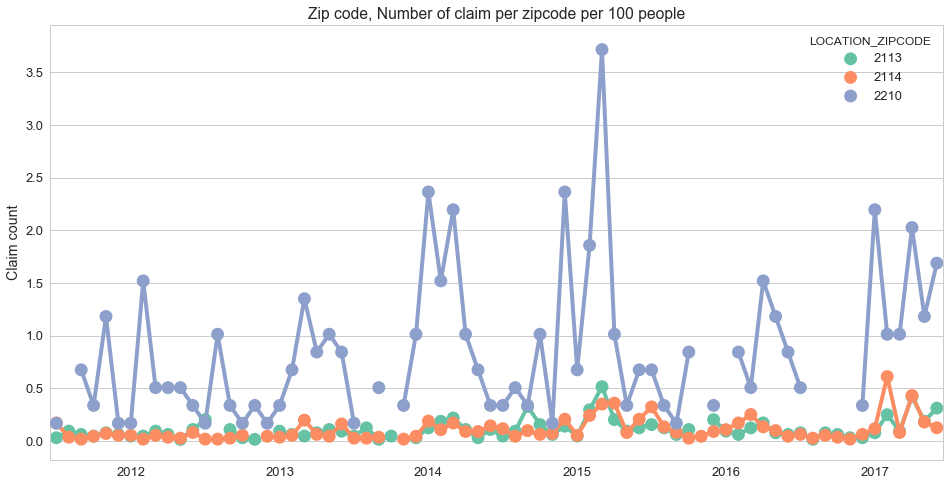

In [245]:
# Set main plot parameters
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.2})

# Create x labels using list comprehension
x_tick = [x.year if x.day==1 and x.month==1 else '' for x in filtered_potholes_df.OPEN_DT.unique()]

# Plot
fig, ax = plt.subplots(figsize=(16,8))


ax = sns.pointplot(x=filtered_potholes_df['OPEN_DT'],
                 y=filtered_potholes_df['pothole_density'],hue=filtered_potholes_df['LOCATION_ZIPCODE'].astype(int),
                 palette="Set2")

# Set plot labels
ax.set_title("Zip code, Number of claim per zipcode per 100 people")
ax.set(xlabel="",ylabel='Claim count')
ax.set_xticklabels(x_tick)

plt.show()

Interstingly, the zip code 2210 (with the largest pothole to people ratio) contains many months without claims.

In [246]:
# Filtered the data to only cover the selected zipcodes
filtered_repair_df = potholes_df[potholes_df.LOCATION_ZIPCODE.isin(selected_zip)][['OPEN_DT','time_repair','LOCATION_ZIPCODE']]
filtered_repair_df = filtered_repair_df[filtered_repair_df.time_repair>=0.5]


# Set all the dates to the first of the month
filtered_repair_df.OPEN_DT = filtered_repair_df.OPEN_DT.apply(lambda x: x.replace(day=1)).dt.date

# Group by date and zip code
filtered_repair_df = filtered_repair_df.groupby(['OPEN_DT','LOCATION_ZIPCODE']).count()

filtered_repair_df.reset_index(drop=False,inplace=True)

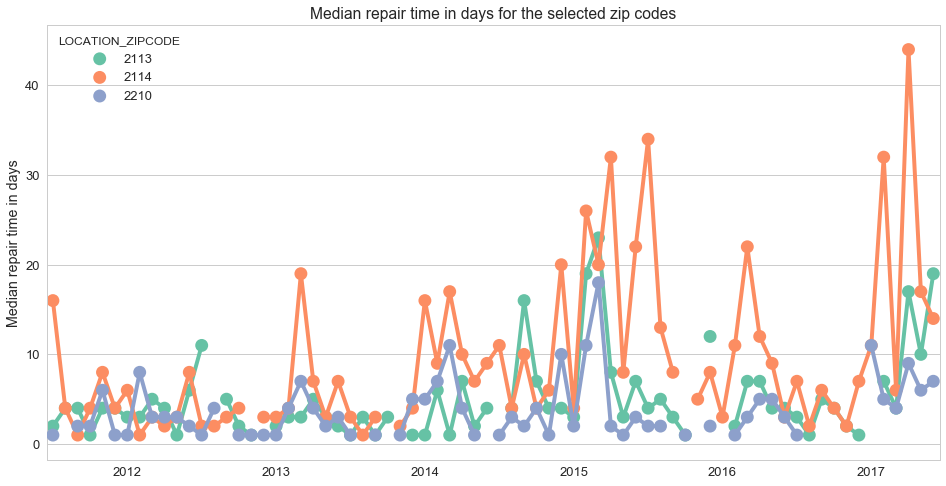

In [247]:
# Set main plot parameters
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.2})

# Create x labels using list comprehension
x_tick = [x.year if x.day==1 and x.month==1 else '' for x in filtered_repair_df.OPEN_DT.unique()]

# Plot
fig, ax = plt.subplots(figsize=(16,8))


ax = sns.pointplot(x=filtered_repair_df['OPEN_DT'],
                 y=filtered_repair_df['time_repair'],hue=filtered_repair_df['LOCATION_ZIPCODE'].astype(int),
                 palette="Set2")

# Set plot labels
ax.set_title("Median repair time in days for the selected zip codes")
ax.set(xlabel="",ylabel='Median repair time in days')
ax.set_xticklabels(x_tick)

plt.show()

The median repair time for the zip code 02114 is extremely volatile. Moreover, it has been increasing on average over the last couple years. A change in the department or funding can explain this trend as the number of potholes has not significantly increase over the same period of time.

# 9. Conclusion

The original questions that were asked at the begining of this study were the followings:
1. Are repairs faster/slower in certain neighborhoods?
2. How does the weather impact the number of claims?
3. How does the weather impact the repair time?

After a detailed review and evaluation of the three sets of data, the following answers can be provided:

1. On average the city is efficient when it comes to fixing potholes reported by 311 calls. However, at least three zipcodes are not as efficient as the rest as fixing a pothole takes more than 20 days on average. Our hypothesis to explain these results are the fact that these three neighborhoods are small with few people with roads that are used by many to commute to work.
2. As expected, the weather has a major impact on the frequency of appearence of potholes. However, we were able to rule out the rain and the "just cold" wheather as the number of claims is direcly correlated to the number of freezing days and the amount of snow fall. Finally, our study show that there is a lag effect of one month between a period of bad weather and a peak in pothole claims.
3. Surprisingly, the city is doing a good job at maintaining an efficient service during and right after a tough winter. With the exception of the winter of 2015 (historic snow fall record), the city is responsive and potholes are typically fixed within couple days on average.


Final words:  
The purpose of this report was to present the different steps that lead to the understanding of a problem. Obviously more questions can be asked regarding this complex topic. We leave room for more exploration in the full project.

As part of the final capstone project report, the following will also be included:
- Does joining a picture to the claim impact the repair time?
- Are the repaired made mostly on time?
- How is the "on time" criterion defined?